In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader, random_split
from torch_pconv import PConv2d  # Partial convolution layer; ensure this is installed.

input: masked image + depth (4 channels)
output: image (3 channels)

Everything is the same from version1 but only the shape of mask is different in version2.

In [2]:
class ImageInpaintingDatasetCSV(Dataset):
    def __init__(self, csv_file, img_size=(160, 240), mask_size=(32, 32), transform=None, apply_mask=True):
        self.data = pd.read_csv(csv_file, header=None)  # Adjust header if needed.
        self.color_paths = self.data.iloc[:, 0].tolist()
        self.depth_paths = self.data.iloc[:, 1].tolist()
        self.img_size = img_size
        self.mask_size = mask_size
        self.transform = transform
        self.apply_mask = apply_mask

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        color_path = self.color_paths[idx]
        depth_path = self.depth_paths[idx]
        # Adjust paths if necessary:
        # For example, if paths in CSV are relative:
        color_path = os.path.join("..\\nyu_data\\", color_path)
        depth_path = os.path.join("..\\nyu_data\\", depth_path)
        
        # Load color image.
        img = cv2.imread(color_path)
        if img is None:
            raise ValueError(f"Color image not found: {color_path}")
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (self.img_size[1], self.img_size[0]))
        img = img.astype(np.float32) / 255.0
        
        # Load depth image (as grayscale).
        depth = cv2.imread(depth_path, cv2.IMREAD_UNCHANGED)
        if depth is None:
            raise ValueError(f"Depth image not found: {depth_path}")
        depth = cv2.resize(depth, (self.img_size[1], self.img_size[0]))
        depth = depth.astype(np.float32) / 255.0  # Adjust normalization as needed.
        
        H, W, _ = img.shape
        
        if self.apply_mask:
            mask = self.create_square_mask((H, W), self.mask_size)  # 0 for masked, 255 for unmasked.
            # Apply mask to color and depth images.
            masked_img = img.copy()
            masked_depth = depth.copy()
            mask_3d = np.stack([mask] * 3, axis=-1)
            masked_img[mask_3d == 0] = 0.0
            masked_depth[mask == 0] = 0.0
        else:
            mask = np.ones((H, W), dtype=np.uint8) * 255
            masked_img = img
            masked_depth = depth
        
        # Convert to torch tensors.
        img_tensor = torch.from_numpy(img).permute(2, 0, 1)             # (3, H, W)
        depth_tensor = torch.from_numpy(depth).unsqueeze(0)               # (1, H, W)
        masked_img_tensor = torch.from_numpy(masked_img).permute(2, 0, 1)   # (3, H, W)
        masked_depth_tensor = torch.from_numpy(masked_depth).unsqueeze(0)   # (1, H, W)
        mask_tensor = torch.from_numpy(mask.astype(np.float32) / 255.0).unsqueeze(0)  # (1, H, W)
        
        # Create combined input and target.
        combined_input = torch.cat([masked_img_tensor, masked_depth_tensor], dim=0)  # (4, H, W)
        target = torch.cat([img_tensor, depth_tensor], dim=0)                        # (3, H, W)
        
        if self.transform:
            combined_input = self.transform(combined_input)
            target = self.transform(target)
            mask_tensor = self.transform(mask_tensor)
        
        return {
            "combined_input": combined_input,
            "target": target,
            "mask": mask_tensor
        }
    
    def create_square_mask(self, image_size, mask_size):
        H, W = image_size
        mH, mW = mask_size
        mask = np.ones((H, W), dtype=np.uint8) * 255

        top1 = np.random.randint(0, H - mH + 1)
        left1 = np.random.randint(0, W - mW + 1)
        mask[top1:top1+mH, left1:left1+mW] = 0

        top2 = np.random.randint(0, H - mH + 1)
        left2 = np.random.randint(0, W - mW + 1)
        mask[top2:top2+mH, left2:left2+mW] = 0

        top3 = np.random.randint(0, H - mH + 1)
        left3 = np.random.randint(0, W - mW + 1)
        mask[top3:top3+mH, left3:left3+mW] = 0
        return mask

In [3]:
class EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, padding=1):
        super(EncoderBlock, self).__init__()
        self.pconv1 = PConv2d(in_channels, out_channels, kernel_size=kernel_size, 
                              stride=1, padding=padding, bias=True)
        self.pconv2 = PConv2d(out_channels, out_channels, kernel_size=kernel_size, 
                              stride=2, padding=padding, bias=True)
    
    def forward(self, x, mask):
        if mask.dim() == 4 and mask.size(1) == 1:
            mask = mask.squeeze(1)
        x1, mask1 = self.pconv1(x, mask)
        x1 = F.relu(x1)
        x2, mask2 = self.pconv2(x1, mask1)
        x2 = F.relu(x2)
        return x1, mask1, x2, mask2

class DecoderBlock(nn.Module):
    def __init__(self, in_channels, skip_channels, out_channels1, out_channels2, kernel_size=3, padding=1):
        super(DecoderBlock, self).__init__()
        self.pconv1 = PConv2d(skip_channels + in_channels, out_channels1, kernel_size=kernel_size, 
                              stride=1, padding=padding, bias=True)
        self.pconv2 = PConv2d(out_channels1, out_channels2, kernel_size=kernel_size, 
                              stride=1, padding=padding, bias=True)
    
    def forward(self, x, mask, skip_x, skip_mask):
        x_up = F.interpolate(x, scale_factor=2, mode='nearest')
        if mask.dim() == 4 and mask.size(1) == 1:
            mask = mask.squeeze(1)
        mask_up = F.interpolate(mask.unsqueeze(1), scale_factor=2, mode='nearest').squeeze(1)
        if skip_mask.dim() == 4 and skip_mask.size(1) == 1:
            skip_mask = skip_mask.squeeze(1)
        mask_cat = torch.max(skip_mask, mask_up)
        x_cat = torch.cat([skip_x, x_up], dim=1)
        x1, mask1 = self.pconv1(x_cat, mask_cat)
        x1 = F.relu(x1)
        x2, mask2 = self.pconv2(x1, mask1)
        x2 = F.relu(x2)
        return x1, mask1, x2, mask2

class InpaintingModel(nn.Module):
    def __init__(self, input_channels=4, output_channels=3):
        super(InpaintingModel, self).__init__()
        self.enc1 = EncoderBlock(input_channels, 8)
        self.enc2 = EncoderBlock(8, 16)
        self.enc3 = EncoderBlock(16, 32)
        self.enc4 = EncoderBlock(32, 64)

        self.dec1 = DecoderBlock(64, 64, 64, 32)
        self.dec2 = DecoderBlock(32, 32, 32, 16)
        self.dec3 = DecoderBlock(16, 16, 16, 8)
        self.dec4 = DecoderBlock(8, 8, 8, output_channels)
        self.final_conv = nn.Conv2d(output_channels, output_channels, kernel_size=3, padding=1)
    
    def forward(self, x, mask):
        if mask.dim() == 4 and mask.size(1) == 1:
            mask = mask.squeeze(1)
        conv1, mask1, conv2, mask2 = self.enc1(x, mask)
        conv3, mask3, conv4, mask4 = self.enc2(conv2, mask2)
        conv5, mask5, conv6, mask6 = self.enc3(conv4, mask4)
        conv7, mask7, conv8, mask8 = self.enc4(conv6, mask6)
        
        dec1, dmask1, dec1_out, dmask1_2 = self.dec1(conv8, mask8, conv7, mask7)
        dec2, dmask2, dec2_out, dmask2_2 = self.dec2(dec1_out, dmask1_2, conv5, mask5)
        dec3, dmask3, dec3_out, dmask3_2 = self.dec3(dec2_out, dmask2_2, conv3, mask3)
        dec4, dmask4, dec4_out, dmask4_2 = self.dec4(dec3_out, dmask3_2, conv1, mask1)
        out = self.final_conv(dec4_out)
        return torch.sigmoid(out)

In [4]:
def dice_coef(y_true, y_pred, epsilon=1e-6):
    y_true_f = y_true.view(-1)
    y_pred_f = y_pred.view(-1)
    intersection = (y_true_f * y_pred_f).sum()
    return (2. * intersection + epsilon) / (y_true_f.sum() + y_pred_f.sum() + epsilon)

In [5]:
def train_one_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    for batch in tqdm(dataloader):
        combined_input = batch["combined_input"].to(device)
        mask = batch["mask"].to(device)
        target = batch["target"].to(device)
        
        optimizer.zero_grad()
        output = model(combined_input, mask)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * combined_input.size(0)
    epoch_loss = running_loss / len(dataloader.dataset)
    return epoch_loss

def validate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    total_dice = 0.0
    with torch.no_grad():
        for batch in dataloader:
            combined_input = batch["combined_input"].to(device)
            mask = batch["mask"].to(device)
            target = batch["target"].to(device)
            output = model(combined_input, mask)
            loss = criterion(output, target)
            running_loss += loss.item() * combined_input.size(0)
            total_dice += dice_coef(target, output).item() * combined_input.size(0)
    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_dice = total_dice / len(dataloader.dataset)
    return epoch_loss, epoch_dice

In [6]:
train_csv = r"C:\Users\user\Desktop\CSCE748_Computational-Photography\nyu_data\data\nyu2_train.csv"
test_csv  = r"C:\Users\user\Desktop\CSCE748_Computational-Photography\nyu_data\data\nyu2_test.csv"

full_train_dataset = ImageInpaintingDatasetCSV(train_csv, img_size=(160, 240), mask_size=(32, 32), apply_mask=True)
train_size = int(0.8 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])  
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_dataset = ImageInpaintingDatasetCSV(test_csv, img_size=(160, 240), mask_size=(32, 32), apply_mask=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

print("Train samples:", len(train_dataset))
print("Val samples:", len(val_dataset))
print("Test samples:", len(test_dataset))

Train samples: 40550
Val samples: 10138
Test samples: 654


In [7]:
def show_sample(sample_dict, idx=0):
    combined_input_np = sample_dict["combined_input"][idx][:3].permute(1, 2, 0).cpu().numpy()
    target_np = sample_dict["target"][idx].permute(1, 2, 0).cpu().numpy()
    depth_input_np = sample_dict["combined_input"][idx][3].cpu().numpy()

    print(np.unique(depth_input_np))

    fig, axs = plt.subplots(1, 3, figsize=(15, 4))

    axs[0].imshow(combined_input_np)
    axs[0].set_title("RGB Image")

    axs[1].imshow(depth_input_np, cmap='gray')
    axs[1].set_title("Depth Image")

    axs[2].imshow(target_np)
    axs[2].set_title("Target")

    plt.tight_layout()
    plt.show()

torch.Size([16, 4, 160, 240])
torch.Size([16, 4, 160, 240])
torch.Size([16, 1, 160, 240])
[0.         0.09411765 0.09803922 0.10196079 0.10588235 0.10980392
 0.11372549 0.11764706 0.12156863 0.1254902  0.12941177 0.13333334
 0.13725491 0.14117648 0.14509805 0.14901961 0.15294118 0.15686275
 0.16078432 0.16470589 0.16862746 0.17254902 0.1764706  0.18039216
 0.18431373 0.1882353  0.19215687 0.19607843 0.2        0.20392157
 0.20784314 0.21176471 0.21568628 0.21960784 0.22352941 0.22745098
 0.23137255 0.23529412 0.23921569 0.24313726 0.24705882 0.2509804
 0.25490198 0.25882354 0.2627451  0.26666668 0.27058825 0.27450982
 0.2784314  0.28235295 0.28627452 0.2901961  0.29411766 0.29803923
 0.3019608  0.30588236 0.30980393 0.3137255  0.31764707 0.32156864
 0.3254902  0.32941177 0.33333334 0.3372549  0.34117648 0.34509805
 0.34901962 0.3529412  0.35686275 0.36078432 0.3647059  0.36862746
 0.37254903 0.3764706  0.38039216 0.38431373 0.3882353  0.39215687
 0.39607844 0.4        0.40392157 0.4078

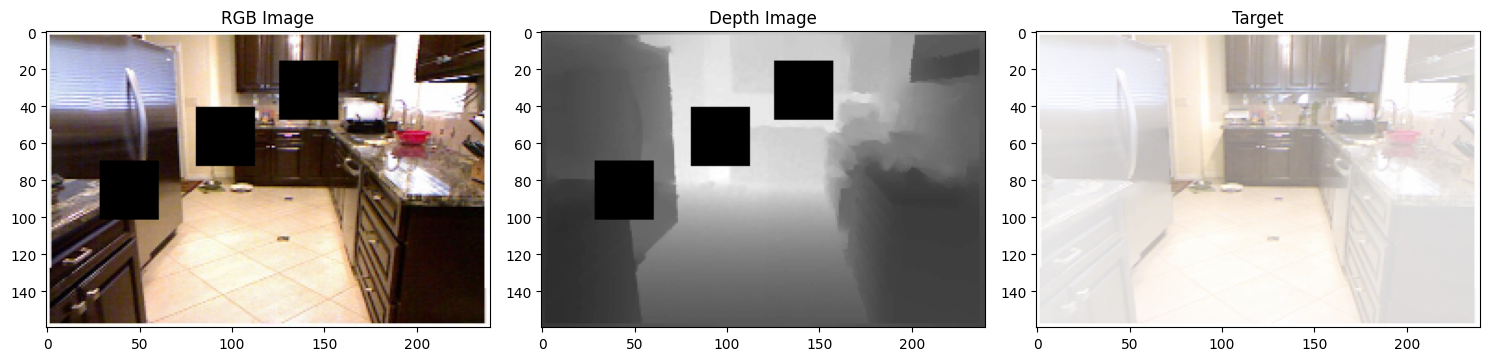

In [8]:
sample_batch = next(iter(train_loader))

print(sample_batch["combined_input"].shape)     # Should be (batch_size, 4, H, W)
print(sample_batch["target"].shape)             # Should be (batch_size, 3, H, W)
print(sample_batch["mask"].shape)               # Should be (batch_size, 1, H, W) 

# Visualize first sample in the batch
show_sample(sample_batch, idx=0)

In [9]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = InpaintingModel(input_channels=4, output_channels=4).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.L1Loss()

num_epochs = 20
best_val_loss = float('inf')
for epoch in range(1, num_epochs+1):
    train_loss = train_one_epoch(model, train_loader, optimizer, criterion, device)
    val_loss, val_dice = validate(model, val_loader, criterion, device)
    print(f"Epoch {epoch}/{num_epochs} - Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Dice: {val_dice:.4f}")
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "nyu_inpainting_depth.pth")
        print(f"Saved best model with Val Loss: {best_val_loss:.4f}")


cuda


c:\Users\user\miniconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| 2535/2535 [07:30<00:00,  5.62it/s]


Epoch 1/20 - Train Loss: 0.0557 | Val Loss: 0.0425 | Val Dice: 0.5781
Saved best model with Val Loss: 0.0425


100%|██████████| 2535/2535 [07:39<00:00,  5.52it/s]


Epoch 2/20 - Train Loss: 0.0389 | Val Loss: 0.0290 | Val Dice: 0.5854
Saved best model with Val Loss: 0.0290


100%|██████████| 2535/2535 [07:40<00:00,  5.51it/s]


Epoch 3/20 - Train Loss: 0.0266 | Val Loss: 0.0242 | Val Dice: 0.5870
Saved best model with Val Loss: 0.0242


100%|██████████| 2535/2535 [06:54<00:00,  6.12it/s]


Epoch 4/20 - Train Loss: 0.0236 | Val Loss: 0.0223 | Val Dice: 0.5879
Saved best model with Val Loss: 0.0223


100%|██████████| 2535/2535 [07:31<00:00,  5.62it/s]


Epoch 5/20 - Train Loss: 0.0221 | Val Loss: 0.0210 | Val Dice: 0.5882
Saved best model with Val Loss: 0.0210


100%|██████████| 2535/2535 [07:38<00:00,  5.52it/s]


Epoch 6/20 - Train Loss: 0.0210 | Val Loss: 0.0216 | Val Dice: 0.5849


100%|██████████| 2535/2535 [06:51<00:00,  6.16it/s]


Epoch 7/20 - Train Loss: 0.0203 | Val Loss: 0.0227 | Val Dice: 0.5845


100%|██████████| 2535/2535 [06:50<00:00,  6.17it/s]


Epoch 8/20 - Train Loss: 0.0198 | Val Loss: 0.0187 | Val Dice: 0.5877
Saved best model with Val Loss: 0.0187


100%|██████████| 2535/2535 [06:50<00:00,  6.17it/s]


Epoch 9/20 - Train Loss: 0.0181 | Val Loss: 0.0164 | Val Dice: 0.5881
Saved best model with Val Loss: 0.0164


100%|██████████| 2535/2535 [06:52<00:00,  6.15it/s]


Epoch 10/20 - Train Loss: 0.0169 | Val Loss: 0.0159 | Val Dice: 0.5881
Saved best model with Val Loss: 0.0159


100%|██████████| 2535/2535 [06:49<00:00,  6.18it/s]


Epoch 11/20 - Train Loss: 0.0164 | Val Loss: 0.0156 | Val Dice: 0.5881
Saved best model with Val Loss: 0.0156


100%|██████████| 2535/2535 [06:52<00:00,  6.15it/s]


Epoch 12/20 - Train Loss: 0.0161 | Val Loss: 0.0156 | Val Dice: 0.5879
Saved best model with Val Loss: 0.0156


100%|██████████| 2535/2535 [06:50<00:00,  6.17it/s]


Epoch 13/20 - Train Loss: 0.0156 | Val Loss: 0.0152 | Val Dice: 0.5880
Saved best model with Val Loss: 0.0152


100%|██████████| 2535/2535 [06:49<00:00,  6.18it/s]


Epoch 14/20 - Train Loss: 0.0155 | Val Loss: 0.0153 | Val Dice: 0.5866


100%|██████████| 2535/2535 [06:49<00:00,  6.19it/s]


Epoch 15/20 - Train Loss: 0.0151 | Val Loss: 0.0157 | Val Dice: 0.5869


100%|██████████| 2535/2535 [04:50<00:00,  8.73it/s]


Epoch 16/20 - Train Loss: 0.0149 | Val Loss: 0.0143 | Val Dice: 0.5863
Saved best model with Val Loss: 0.0143


100%|██████████| 2535/2535 [05:17<00:00,  7.97it/s]


Epoch 17/20 - Train Loss: 0.0147 | Val Loss: 0.0136 | Val Dice: 0.5887
Saved best model with Val Loss: 0.0136


100%|██████████| 2535/2535 [05:22<00:00,  7.87it/s]


Epoch 18/20 - Train Loss: 0.0145 | Val Loss: 0.0137 | Val Dice: 0.5885


100%|██████████| 2535/2535 [05:20<00:00,  7.91it/s]


Epoch 19/20 - Train Loss: 0.0142 | Val Loss: 0.0135 | Val Dice: 0.5894
Saved best model with Val Loss: 0.0135


100%|██████████| 2535/2535 [05:16<00:00,  8.01it/s]


Epoch 20/20 - Train Loss: 0.0142 | Val Loss: 0.0131 | Val Dice: 0.5881
Saved best model with Val Loss: 0.0131


cuda
Sample 0:
SSD between Inpainted vs GT: 28318.947
SSD between Masked vs GT: 1410.4413
Sample 1:
SSD between Inpainted vs GT: 27247.264
SSD between Masked vs GT: 2197.5063
Sample 2:
SSD between Inpainted vs GT: 27559.492
SSD between Masked vs GT: 1223.7576


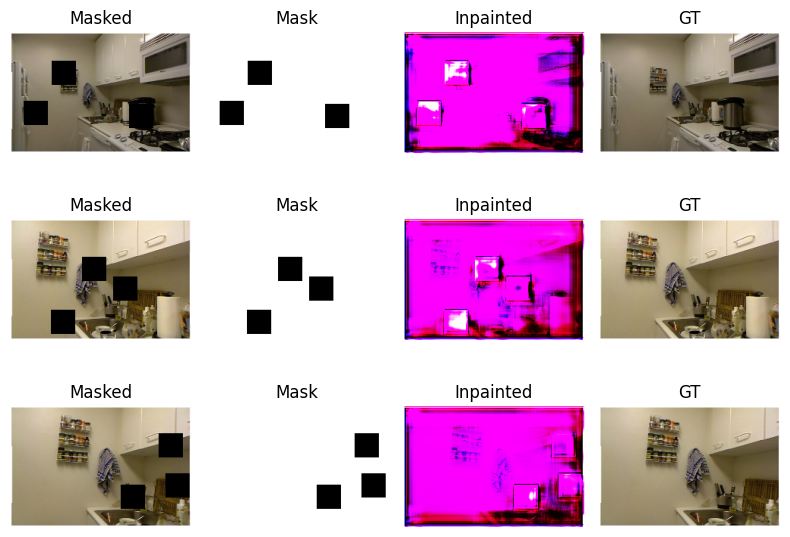

In [12]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = InpaintingModel(input_channels=4, output_channels=4).to(device)
model.load_state_dict(torch.load("nyu_inpainting_depth.pth", map_location=device))
model.eval()

# Visualization: select a few samples from the test dataset.
sample_idx = 54
rows = 3
samples = [test_dataset[i] for i in range(sample_idx, sample_idx + rows)]
masked_images = torch.stack([s["combined_input"] for s in samples], dim=0)
masks = torch.stack([s["mask"] for s in samples], dim=0)
sample_labels = torch.stack([s["target"] for s in samples], dim=0)

inpainted_images = []
with torch.no_grad():
    for i in range(rows):
        input_masked = masked_images[i].unsqueeze(0).to(device)
        input_mask = masks[i].unsqueeze(0).to(device)
        pred = model(input_masked, input_mask)
        inpainted_images.append(pred.squeeze(0).cpu())

fig, axs = plt.subplots(nrows=rows, ncols=4, figsize=(8, 2*rows))
for i in range(rows):
    # For display, we show only the RGB part (channels 0-2).
    masked_np = masked_images[i][:3].permute(1, 2, 0).cpu().numpy()
    mask_np = masks[i].squeeze(0).cpu().numpy()
    inpainted_np = inpainted_images[i][:3].permute(1, 2, 0).cpu().numpy()
    gt_color = sample_labels[i][:3].permute(1, 2, 0).cpu().numpy()
    
    print(f"Sample {i}:")
    print("SSD between Inpainted vs GT:", np.sum((inpainted_np - gt_color)**2))
    print("SSD between Masked vs GT:", np.sum((masked_np - gt_color)**2))
    
    axs[i, 0].imshow(masked_np)
    axs[i, 0].set_title("Masked")
    axs[i, 0].axis("off")
    
    axs[i, 1].imshow(mask_np, cmap="gray")
    axs[i, 1].set_title("Mask")
    axs[i, 1].axis("off")
    
    axs[i, 2].imshow(inpainted_np)
    axs[i, 2].set_title("Inpainted")
    axs[i, 2].axis("off")
    
    axs[i, 3].imshow(gt_color)
    axs[i, 3].set_title("GT")
    axs[i, 3].axis("off")
    
plt.tight_layout()
plt.show()